### Test bandits with new beta

In [17]:
%pylab inline
%cd /home/lansdell/projects/conservativerdd
pylab.rcParams['figure.figsize'] = (6, 6)

from lib.bandits import LinUCB, ThresholdBandit,ThresholdConsBandit, GreedyBandit, ThresholdMaxConsBandit, \
               ThresholdMaxConsGreedyBandit ,ThresholdBaselineBandit, ConsLinUCB, expected_regret, expected_regret_per_arm
from lib.generator import LinearGeneratorParams, LinearGenerator
import numpy as np 

import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import seaborn as sns
sns.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib
/home/lansdell/projects/conservativerdd


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['save']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#alg = 'greedy'
#alg = 'linucb'
#alg = 'threshold'
#alg = 'thresholdcons'
#alg = 'conslinucb'
alg = 'thrbaseline'

M = 3    #number of runs
N = 10000 #number of timesteps
save = False
max_alpha = 2
max_beta = 2
k = 4    #Number of arms
d = 5   #Dimension of context (includes one dim for intercept term)
intercept = True
evaluate_every = 100

if alg == 'greedy':
	BanditAlg = GreedyBandit
elif alg == 'linucb':
	BanditAlg = LinUCB
elif alg == 'threshold':
	BanditAlg = ThresholdBandit
elif alg == 'thresholdcons':
	BanditAlg = ThresholdConsBandit
elif alg == 'conslinucb':
	BanditAlg = ConsLinUCB
elif alg == 'thrbaseline':
	BanditAlg = ThresholdBaselineBandit
else:
	print "Select a valid algorithm"

## Run baseline bandit 

In [3]:
#Generate slopes and intercepts
alphas = truncnorm.rvs(-max_alpha, max_alpha, scale = 1, size=(M,k,d-1))
betas = truncnorm.rvs(-max_beta, max_beta, scale = 1, size=(M,k))

baseline_params = truncnorm.rvs(-max_alpha, max_alpha, scale = 1, size=(M,k,d))

regret = np.zeros((M, N))
expt_regret = np.zeros((M, N))
arm_pulls = np.zeros((M, N, k+1))
n_changes = np.zeros((M, N))
update_pol = np.zeros((M, N))

In [4]:
print("Running %s algorithm"%alg)
BanditAlg = ThresholdBaselineBandit

for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator, baseline_params[m,:,:], delta = 1./N)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret[m,i] = r
        if arm_idx >= 0:
            arm_pulls[m,i,arm_idx] = 1
        else:
            arm_pulls[m,i,k] = 1
    update_pol[m,:] = bandit.update_theta 

Running thrbaseline algorithm
Run: 1/3
Run: 2/3
Run: 3/3


## LinUCB for comparison

In [5]:
BanditAlg = LinUCB    
regret_linucb = np.zeros((M, N))
arm_pulls_linucb = np.zeros((M, N, k+1))
update_pol_linucb = np.zeros((M, N))

In [6]:
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret_linucb[m,i] = r
        if arm_idx >= 0:
            arm_pulls_linucb[m,i,arm_idx] = 1
        else:
            arm_pulls_linucb[m,i,k] = 1
    #update_pol_linucb[m,:] = bandit.update_theta 

Run: 1/3
Run: 2/3
Run: 3/3


## ConsLinUCB for comparison

In [7]:
BanditAlg = ConsLinUCB    
regret_clinucb = np.zeros((M, N))
arm_pulls_linucb = np.zeros((M, N, k+1))
update_pol_linucb = np.zeros((M, N))
alpha = 0.1

In [8]:
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    means = expected_regret_per_arm(generator)
    #Choose the baseline arm as the worst arm....
    m_idx = np.argmin(means)
    base_alpha = alphas[m,m_idx,:]
    base_beta = betas[m,m_idx]
    bandit = BanditAlg(generator, (base_alpha, base_beta), alpha = alpha)
    
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret_clinucb[m,i] = r
        if arm_idx >= 0:
            arm_pulls_linucb[m,i,arm_idx] = 1
        else:
            arm_pulls_linucb[m,i,k] = 1
    #update_pol_linucb[m,:] = bandit.update_theta 

Run: 1/3
Run: 2/3
Run: 3/3


## Threshold greedy for comparison

In [9]:
BanditAlg = ThresholdBandit    
regret_thrgre = np.zeros((M, N))
arm_pulls_thrgre = np.zeros((M, N, k+1))
update_pol_thrgre = np.zeros((M, N))

In [10]:
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret_thrgre[m,i] = r
        if arm_idx >= 0:
            arm_pulls_thrgre[m,i,arm_idx] = 1
        else:
            arm_pulls_thrgre[m,i,k] = 1
    update_pol_thrgre[m,:] = bandit.update_theta 

Run: 1/3
Run: 2/3
Run: 3/3


## Threshold conservative for comparison

In [11]:
BanditAlg = ThresholdConsBandit    
regret_thrcons = np.zeros((M, N))
arm_pulls_thrcons = np.zeros((M, N, k+1))
update_pol_thrcons = np.zeros((M, N))

In [12]:
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret_thrcons[m,i] = r
        if arm_idx >= 0:
            arm_pulls_thrgre[m,i,arm_idx] = 1
        else:
            arm_pulls_thrgre[m,i,k] = 1
    update_pol_thrcons[m,:] = bandit.update_theta 

Run: 1/3
Run: 2/3
Run: 3/3


## Max con greedy for comparison

In [18]:
BanditAlg = ThresholdMaxConsGreedyBandit    
regret_thrgre = np.zeros((M, N))
arm_pulls_thrgre = np.zeros((M, N, k+1))
update_pol_thrgre = np.zeros((M, N))

In [19]:
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret_thrgre[m,i] = r
        if arm_idx >= 0:
            arm_pulls_thrgre[m,i,arm_idx] = 1
        else:
            arm_pulls_thrgre[m,i,k] = 1
    update_pol_thrgre[m,:] = bandit.update_theta 

Run: 1/3
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Run: 2/3
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Run: 3/3
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde


## Max con for comparison

In [20]:
BanditAlg = ThresholdMaxConsBandit    
regret_thrcons = np.zeros((M, N))
arm_pulls_thrcons = np.zeros((M, N, k+1))
update_pol_thrcons = np.zeros((M, N))

In [21]:
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    bandit = BanditAlg(generator)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        #print(ctx, arm_idx)
        regret_thrcons[m,i] = r
        if arm_idx >= 0:
            arm_pulls_thrgre[m,i,arm_idx] = 1
        else:
            arm_pulls_thrgre[m,i,k] = 1
    update_pol_thrcons[m,:] = bandit.update_theta 

Run: 1/3
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Run: 2/3
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Run: 3/3
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde
Updating theta_tilde


## Comparison of the methods

Trade-off between convergence rate, risk, and confidence level

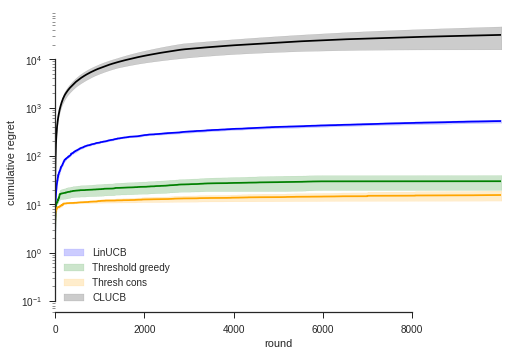

In [16]:
#Vary the confidence level, plot convergence rate, regret, risk
#sns.tsplot(np.cumsum(regret, axis = 1), color = 'red')
sns.tsplot(np.cumsum(regret_linucb, axis = 1), color = 'blue')
sns.tsplot(np.cumsum(regret_thrgre, axis = 1), color = 'green')
sns.tsplot(np.cumsum(regret_thrcons, axis = 1), color = 'orange')
sns.tsplot(np.cumsum(regret_clinucb, axis = 1), color = 'black')
plt.xlabel('round')
plt.ylabel('cumulative regret')
plt.yscale('log')
#plt.legend(['BaselineBandit', 'LinUCB', 'Threshold greedy', 'Thresh cons'])
plt.legend(['LinUCB', 'Threshold greedy', 'Thresh cons', 'CLUCB'])
sns.despine(trim = True)

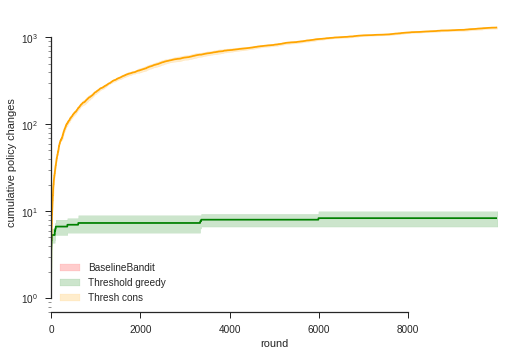

In [14]:
#Vary the confidence level, plot convergence rate, regret, risk
sns.tsplot(np.cumsum(update_pol, axis = 1), color = 'red')
sns.tsplot(np.cumsum(update_pol_thrgre, axis = 1), color = 'green')
sns.tsplot(np.cumsum(update_pol_thrcons, axis = 1), color = 'orange')
plt.xlabel('round')
plt.ylabel('cumulative policy changes')
plt.yscale('log')
plt.legend(['BaselineBandit', 'Threshold greedy', 'Thresh cons'])
sns.despine(trim = True)